In [17]:
import os
import sys

AeroBDSM_OOP_dir = os.path.abspath(os.path.join('../AERO_LIB/'))
if AeroBDSM_OOP_dir not in sys.path:
    sys.path.append(AeroBDSM_OOP_dir)

PyXfoil_dir = os.path.abspath(os.path.join('../mpyXfoil/'))
if PyXfoil_dir not in sys.path:
    sys.path.append(PyXfoil_dir)

import pyXfoil as pxf
from isolated_plane import *
from libs.Atmosphere import atmo
from math import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz
from scipy.integrate import quad

from pandas import DataFrame, read_excel
%config InlineBackend.figure_format = 'svg'

# Задание формата шрифта для графиков
plt.rcParams["font.family"] = 'serif'
plt.rcParams['font.weight'] = 'ultralight'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams['font.style'] = 'normal'
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['mathtext.fontset'] = 'stix'

import warnings
warnings.filterwarnings("ignore")

In [18]:
# Геометрические параметры несущей поверхности

# Параметры крыла
l_kr = 2.5            # размах крыла [м]
l_c = 2.5/2             # длина одной консоли [м]
b_b = 0.5             # бортовая хорда [м]
b_1 = 0.5             # концевая хорда [м]
chi_0 = radians(0)  # угол стреловидности по передней кромке [рад]
chi_1 = radians(0)      # угол стреловидности по задней кромке [рад]

# Параметры профиля крыла
cc_b = 0.12            # относительная толщина профиля бортовой хорды [-]
cc_1 = 0.12            # относительная толщина профиля концевой хорды [-]
cc = (cc_b + cc_1) / 2  # средняя относительная толщина профиля [-]
xx_c = 0.3              # относительная координата положения максимальной толщины [-]
hb = 1e-3               # относительная высота бугорков профиля [-]
rr_0 = 1                # относительный радиус скругления передней кромки [-]
aa = 0.5                # отношение геометрического параметра профиля `a` в долях рассматриваемой хорды [-]

xx_0 = 0                # относительная координата центра вращения в долях САХ (от носка САХ) относительно которой считаются моменты
xx_t = None             # относительная координата перехода пограничного слоя из ламинарного в турбулентный в долях рассматриваемой хорды
T_s = None              # средняя температура поверхности крыла, К

# Расчет геометрических параметров

S_kr = (b_b + b_1) / 2 * l_kr
lambda_kr = l_kr ** 2 / S_kr
zeta_kr = b_1 / b_b
chi_05 = atan(tan(chi_0) - 2 / lambda_kr * (1 / zeta_kr - 1) / (1 / zeta_kr + 1))

In [19]:
def c_x(X, q, S):
    return X / q / S

def c_y(Y, q, S):
    return Y / q / S

def m_z(M_z, q, S, L):
    return M_z / q / S / L

def m_x(M_x, q, S, L):
    return M_x / q / S / L

def c_y_to_c_ya(alpha, cy, cx):
    return cy * np.cos(np.deg2rad(alpha)) - cx * np.sin(np.deg2rad(alpha))

def c_x_to_c_xa(alpha, cy, cx):
    return cy * np.sin(np.deg2rad(alpha)) + cx * np.cos(np.deg2rad(alpha))

# Функции из Фролова
def get_c_ya_alpha_rect(lambd, c_y_a_alpha_profile):
    '''
    Расчет производной коэффициента c_y_a по углу атаки для прямоугольного крыла
    
    Ввод:   lambd: float - удлинение крыла
            c_y_a_alpha_profile: float - производная коэффициена c_y_a профиля по углу атаки
    Вывод:  c_y_alpha: float - производной коэффициента c_y_a по углу атаки для прямоугольного крыла, 1/рад
    '''

    c_y_a_alpha = (c_y_a_alpha_profile) / (1 + c_y_a_alpha_profile*0.375/lambd)

    return c_y_a_alpha

def get_c_ya_alpha_profile_rect(lambd, c_y_a_alpha):
    '''
    Расчет производной коэффициента c_y_a по углу атаки для профиля прямоугольного крыла
    
    Ввод:   lambd: float - удлинение крыла
            c_y_a_alpha: float - производная коэффициена c_y_a прямоугольного крыла по углу атаки
    Вывод:  c_y_a_alpha_profile: float - производной коэффициента c_y_a по углу атаки профиля прямоугольного крыла, 1/рад
    '''
    c_y_a_alpha_profile = c_y_a_alpha / (1 - c_y_a_alpha * 0.375 / lambd)
    return c_y_a_alpha_profile

def get_c_ya_alpha_rect_eta(lambd, z, c_ya_alpha_profile):
    '''
    Расчет производной коэффициента c_y_a по углу атаки для прямоугольного крыла
    
    Ввод:   lambd: float - удлинение крыла
            z: float - обратное сужение крыла (z = 1/eta = 1/(b_0/b_k))
            c_ya_alpha_profile: float - производная коэффициена c_y_a профиля по углу атаки
    Вывод:  c_y_alpha: float - производной коэффициента c_y_a по углу атаки для прямоугольного крыла, 1/рад
    '''

    k = 0.995 # Поправочный коэффициент, учит. сужение крыла для 0,2 < z < 1,0
    E = 1 + 2*z / lambd / (1 + z) # Поправка Джонса, учитывает фактоор скорости по кромке, равна отношению периметра в плане к размаху

    c_ya_alpha = k * c_ya_alpha_profile / (E + c_ya_alpha_profile / np.pi / lambd)
    return c_ya_alpha

def get_c_ya_alpha_chi(lambd, chi_05, c_ya_alpha_profile):
    '''
    Расчет производной коэффициента c_y_a по углу атаки для крыла со стреловидностью
    
    Ввод:   lambd: float - удлинение крыла
            chi_05: float - угол стреловидности по линии средин хорд, рад
            c_ya_alpha_profile: float - производная коэффициена c_y_a профиля по углу атаки
    Вывод:  c_y_alpha: float - производной коэффициента c_y_a по углу атаки для прямоугольного крыла, 1/рад
    '''

    c_y_a_alpha = (c_ya_alpha_profile * np.cos(chi_05)) / (1 + (c_ya_alpha_profile * np.cos(chi_05)) / np.pi / lambd)

    return c_y_a_alpha

def get_c_ya_alpha_Dzhons_low_lambda(lambd):
    '''
    Расчет производной коэффициента c_y_a по углу атаки для крыла малого удлинения (lambda<1) по формуле Джонса
    
    Ввод:   lambd: float - удлинение крыла
            
    Вывод:  c_y_alpha: float - производной коэффициента c_y_a по углу атаки для крыла малого удлинения, 1/рад
    '''

    c_y_a_alpha = np.pi * lambd / 2

    return c_y_a_alpha

def get_c_ya_alpha_Dzhons(lambd, chi_pk, chi_zk, z):
    '''
    Расчет производной коэффициента c_y_a по углу атаки для крыла малого удлинения (lambda<1)
    
    Ввод:   lambd: float - удлинение крыла
            
    Вывод:  c_y_alpha: float - производной коэффициента c_y_a по углу атаки для крыла малого удлинения, 1/рад
    '''
    eta = 1 / z # сужение крыла
    # Отношение полупериметра крыла к его размаху для трапециевидных крыльев
    pp = 1/2 * (1/np.cos(chi_pk) + 1/np.cos(chi_zk)) * (2 / lambd / (eta + 1))

    c_y_a_alpha = 2 * np.pi * lambd / (pp * lambd + 2)

    return c_y_a_alpha

def get_c_xa_i(lambd, z, chi_025, c_y_a):
    '''
    Расчет коэффициента индуктивного сопротивления крыла

    Ввод: 
        lambd: float - удлинение крыла
        z: float - облатное сужение крыла
        chi_025: float - угол стреловидности по линии 1/4 хорд, рад
        c_y_a: float - коэффициент подъемной силы крыла
    Вывод:
        c_xa_i: float - коэффициент индуктивного сопротивления
    '''
    eta = 1 / z # сужение крыла
    delta = 0.002 * lambd / np.cos(chi_025) * (3.1 - 14/eta + 20/eta/eta - 8/eta/eta/eta)

    lambd_eff = lambd / (1 + delta) # эффективное удлинение крыла
    c_xa_i = c_y_a ** 2 / np.pi / lambd_eff

    return c_xa_i

def get_c_y_a_alpha(alphas, c_y_a):
    """
    Расчет производной по углу атаки коэффициента c_y_a

    Ввод:
        alphas: np.array - массив углов атаки, град
        c_y_a: np.array - массив коэффициентов подъемной силы c_y_a
    Вывод:
        c_y_a_alpha: float - производная коэффициента подъменой силы c_y_a, 1/рад
    """
    c_y_a_alpha = (c_y_a[2] - c_y_a[0]) / (alphas[2] - alphas[0])
    return c_y_a_alpha

In [20]:
# Результаты расчета в Ansys

alpha_Ansys = np.array([0, 2, 4, 8, 12, 16])

cxa_Ansys = np.array([0.01024871, 0.01169752, 0.01607037, 0.03400446, 0.06367909, 0.16330742])
cya_Ansys = np.array([1.06787254e-04, 1.37893522e-01, 2.76604566e-01, 5.51021198e-01, 7.88472609e-01, 6.76273519e-01])
mza_Ansys = np.array([3.37402638e-05, 1.52577015e-02, 3.08446023e-02, 6.22609739e-02, 8.85198277e-02, 1.05769155e-01])
# Параметры невозмущенного потока
H_Ansys = 0                         # Высота полета
rho_Ansys = atmo.rho(H_Ansys)       # Плотность воздуха
a_Ansys = atmo.a(H_Ansys)           # Скорость звука
nu_Ansys = 15.06e-6                 # Кинематическая вязкость воздуха

# M = 0.2                             # Число Маха
V = 68                    # Скорость потока
M = V / a_Ansys
q = rho_Ansys * V ** 2 / 2          # Скоростной напор

Re_Ansys = V * b_b / nu_Ansys       # Число Рейнольдса для крыла

In [21]:
# Расчет АДХ профиля крыла по Xfoil
S = pxf.Session()
EXP = pxf.Experiment()

AIRFOIL = 'NACA0012'        # Имя профиля (имя профиля или файл с координатами профиля)
Re = Re_Ansys               # Число Рейнольдса
ITER = 70                 # Число итераций
INIT_TYPE_ADX = 'alpha'     # Инициализация расчета (по c_ya или alpha)
value_min = -0.5            # Значение c_ya или alpha
value_max = 20
inc = 1

Res_ADX = S.get_ADX(AIRFOIL, Re, INIT_TYPE_ADX, value_min, value_max, inc, ITER)
alpha_airfoil, c_ya_airfoil, c_xa_airfoil = Res_ADX['alpha'], Res_ADX['c_ya'], Res_ADX['c_xa']

In [22]:
# Расчет производных коэффициента c_y_a по углу атаки alpha
c_y_a_alpha_Xfoil = (c_ya_airfoil[1] - c_ya_airfoil[0]) / (alpha_airfoil[1] / 57.3 - alpha_airfoil[0] / 57.3)
# c_y_a_alpha_Xfoil = get_c_y_a_alpha(alpha_airfoil, c_ya_airfoil)        # Производная c_y_a_alpha из Xfoil
c_y_a_alpha_1 = get_c_ya_alpha_rect(lambda_kr, c_y_a_alpha_Xfoil) / 57.3
c_y_a_alpha_2 = get_c_ya_alpha_rect_eta(lambda_kr, 1, c_y_a_alpha_Xfoil) / 57.3
c_y_a_alpha_3 = get_c_ya_alpha_chi(lambda_kr, chi_05, c_y_a_alpha_Xfoil) / 57.3
c_y_a_alpha_4 = get_c_ya_alpha_Dzhons_low_lambda(lambda_kr) / 57.3
c_y_a_alpha_5 = get_c_ya_alpha_Dzhons(lambda_kr, chi_0, chi_1, 1) / 57.3

delta_c_ya = c_ya_airfoil[0] / (1 + c_y_a_alpha_Xfoil * 0.375 / lambda_kr) * 0

In [23]:
(c_ya_airfoil[1] - c_ya_airfoil[0]) / (alpha_airfoil[1] - alpha_airfoil[0]) * 57.3

6.38322

In [24]:
def get_derivative_function(x, y):
    '''
    Расчет функции производной
    Ввод: y: numpy.ndarray - массив значений функции
          x: numpy.ndarray - массив аргументов функции

    Вывод: y_: numpy.ndarray - массив значений производной функции
    '''

    f_int = interp1d(x, y)
    y_ = np.gradient(f_int(x), x)

    return y_

def get_integration_function(x_, y_, cya_0):
    '''
    Расчет функции по её производной
    Ввод: y_: numpy.ndarray - массив значений производной функции
          x_: numpy.ndarray - массив аргументов производной функции
          cya_0: float - значение функции при первом значении аргумента

    Вывод: y: numpy.ndarray - массив значений функции
    '''

    # интегрирвоание
    y = cumtrapz(y_, x_, dx = 0.01, initial=0)

    # Результат
    return y + cya_0


cya_0 = c_ya_airfoil[0]
c_y_alpha_pr_s = get_derivative_function(alpha_airfoil, c_ya_airfoil)
c_y_a_after_integr = get_integration_function(alpha_airfoil, c_y_alpha_pr_s, cya_0)

In [25]:
# АДХ крыла конечного размаха

c_y_alpha_kr_s = []

for cya_alf in c_y_alpha_pr_s:
    cya_alf_kr = get_c_ya_alpha_rect_eta(lambda_kr, 1, cya_alf * 57.3)
    c_y_alpha_kr_s.append(cya_alf_kr / 57.3)

c_y_a_kr = get_integration_function(alpha_airfoil, c_y_alpha_kr_s, cya_0)

In [26]:
alpha_analit = np.array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,
        2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,
        4.4,  4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,  6.4,
        6.6,  6.8,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2,  8.4,  8.6,
        8.8,  9. ,  9.2,  9.4,  9.6,  9.8, 10. , 10.2, 10.4, 10.6, 10.8,
       11. , 11.2, 11.4, 11.6, 11.8, 12. , 12.2, 12.4, 12.6, 12.8, 13. ,
       13.2, 13.4, 13.6, 13.8, 14. , 14.2, 14.4, 14.6, 14.8, 15. , 15.2,
       15.4, 15.6, 15.8, 16. , 16.2, 16.4, 16.6, 16.8, 17. , 17.2, 17.4,
       17.6, 17.8, 18. , 18.2, 18.4, 18.6, 18.8, 19. , 19.2, 19.4, 19.6,
       19.8, 20. ]) 

cya_analit = np.array([0.0,
 0.015030238198808756,
 0.03006047639761751,
 0.045090714596426267,
 0.06012095279523502,
 0.07515119099404377,
 0.09018142919285253,
 0.1052116673916613,
 0.12024190559047004,
 0.1352721437892788,
 0.15030238198808754,
 0.16533262018689632,
 0.18036285838570507,
 0.19539309658451381,
 0.2104233347833226,
 0.2254535729821313,
 0.2404838111809401,
 0.25551404937974886,
 0.2705442875785576,
 0.28557452577736636,
 0.3006047639761751,
 0.31563500217498386,
 0.33066524037379263,
 0.3456954785726014,
 0.36072571677141013,
 0.37575595497021885,
 0.39078619316902763,
 0.4058164313678364,
 0.4208466695666452,
 0.4358769077654539,
 0.4509071459642626,
 0.4659373841630714,
 0.4809676223618802,
 0.49599786056068895,
 0.5110280987594977,
 0.5260583369583064,
 0.5410885751571152,
 0.556118813355924,
 0.5711490515547327,
 0.5861792897535415,
 0.6012095279523502,
 0.616239766151159,
 0.6312700043499677,
 0.6463002425487764,
 0.6613304807475853,
 0.6763607189463939,
 0.6913909571452028,
 0.7064211953440115,
 0.7214514335428203,
 0.736481671741629,
 0.7515119099404377,
 0.7665421481392466,
 0.7815723863380553,
 0.796602624536864,
 0.8116328627356728,
 0.8266631009344815,
 0.8416933391332904,
 0.856723577332099,
 0.8717538155309078,
 0.8867840537297166,
 0.9018142919285252,
 0.9168445301273341,
 0.9318747683261428,
 0.9469050065249516,
 0.9619309318170339,
 0.9753504184684401,
 0.9858649916142896,
 0.9934746512545845,
 0.9981793973893227,
 0.9999792300185062,
 0.998874149142134,
 0.9962464003165038,
 0.9936177818460117,
 0.9909891633755197,
 0.9883605449050276,
 0.9857319264345354,
 0.9831033079640433,
 0.9804746894935512,
 0.9778460710230592,
 0.9752174525525671,
 0.972588834082075,
 0.9699602156115829,
 0.9673315971410907,
 0.9647029786705987,
 0.9620743602001066,
 0.9594457417296145,
 0.9568171232591224,
 0.9541885047886303,
 0.9515598863181383,
 0.9489312678476461,
 0.946302649377154,
 0.9436740309066619,
 0.9410454124361698,
 0.9384167939656778,
 0.9357881754951857,
 0.9331595570246936,
 0.9305309385542014,
 0.9279023200837093,
 0.9252737016132173,
 0.9226450831427251,
 0.9200164646722331])

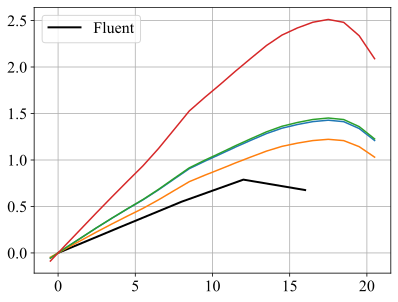

In [28]:
plt.plot(alpha_Ansys, cya_Ansys, label = 'Fluent', lw = 2, color = 'black')
plt.plot(alpha_airfoil, get_c_ya_alpha_rect(lambda_kr, c_ya_airfoil))
plt.plot(alpha_airfoil, get_c_ya_alpha_rect_eta(lambda_kr, 1, c_ya_airfoil))
plt.plot(alpha_airfoil, get_c_ya_alpha_chi(lambda_kr, chi_05, c_ya_airfoil))
plt.plot(alpha_airfoil, get_c_ya_alpha_Dzhons_low_lambda(c_ya_airfoil))
# plt.plot(alpha_airfoil, get_c_ya_alpha_Dzhons(lambda_kr, chi_0, chi_1, 1))

plt.grid()
plt.legend()
# get_c_ya_alpha_rect(lambda_kr, c_y_a_alpha_Xfoil) / 57.3
# c_y_a_alpha_2 = get_c_ya_alpha_rect_eta(lambda_kr, 1, c_y_a_alpha_Xfoil) / 57.3
# c_y_a_alpha_3 = get_c_ya_alpha_chi(lambda_kr, chi_05, c_y_a_alpha_Xfoil) / 57.3
# c_y_a_alpha_4 = get_c_ya_alpha_Dzhons_low_lambda(lambda_kr) / 57.3
# c_y_a_alpha_5 = get_c_ya_alpha_Dzhons(lambda_kr, chi_0, chi_1, 1) / 57.3

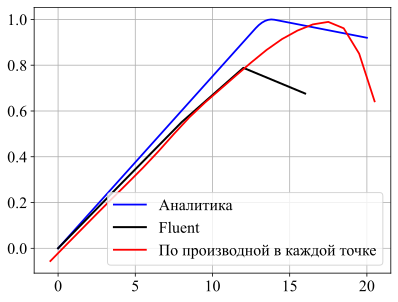

In [ ]:
# plt.plot(alpha_airfoil, c_y_alpha_pr_s)

# plt.plot(alpha_airfoil, c_y_a_after_integr)
# plt.plot(alpha_airfoil, c_ya_airfoil)
plt.plot(alpha_analit, cya_analit, lw = '1.8', color = 'blue', label = 'Аналитика')
plt.plot(alpha_Ansys, cya_Ansys, label = 'Fluent', lw = 2, color = 'black')
plt.plot(alpha_airfoil, c_y_a_kr + delta_c_ya, color = 'red', lw = 1.8, label = 'По производной в каждой точке')

plt.grid()
plt.legend()